# GenAI with Python: Agents from scratch

###### [Article: TowardsDataScience](https://towardsdatascience.com/genai-with-python-build-agents-from-scratch-complete-tutorial-4fc1e084e2ec)

### 0 - Setup

In [1]:
#pip install langchain --> 0.2.14
#pip install langgraph --> 0.2.19
#pip install ollama --> 0.3.1
#pip install duckduckgo-search --> 6.2.12
#pip install wikipedia --> 1.4.0

In [46]:
import ollama

llm = "phi3:mini"
q = '''Did any G7 countries revise their 2030 carbon emission targets in 2024 ? If yes, which ones, and what are the new goals?. make a short answer using bullet points'''

res = ollama.chat(model=llm, 
                  messages=[{"role":"system", "content":""},
                            {"role":"user", "content":q}])
res

ChatResponse(model='phi3:mini', created_at='2025-05-08T23:22:19.176064Z', done=True, done_reason='stop', total_duration=3689467750, load_duration=14984083, prompt_eval_count=52, prompt_eval_duration=316810500, eval_count=168, eval_duration=3355150208, message=Message(role='assistant', content='- Germany: Increased its target from 55% to 65%. New goal is now -75% compared to 1990 levels.\n- Canada: Updated its aim for net zero emissions, increasing it by five years to 2030 and included the use of carbon capture technology in certain sectors. The new target becomes a reduction of at least 40-45% below 2decade-average 2003 - 2019 levels.\n- Italy: Increased its renewable energy goal from 33% to 38%. New carbon emission targets not officially announced yet, but aim for a reduction of at least 33% by 2030 based on 2005 level.', images=None, tool_calls=None))

### 1 - Tools

In [47]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool("tool_browser")
def tool_browser(q:str) -> str:
    """Search on DuckDuckGo browser by passing the input `q`"""
    return DuckDuckGoSearchRun().run(q)

# test
print (q)
print( tool_browser(q) )

Did any G7 countries revise their 2030 carbon emission targets in 2024 ? If yes, which ones, and what are the new goals?. make a short answer using bullet points
Sufficient goals, like those associated with limiting global warming to a maximum of 2° Celsius, are missed by many and insufficient goals, like limiting it to 3° Celsius, continue to exist for ... This infographic shows the greenhouse gas emissions reductions targets of all countries around the globe by their target year and level of commitment with data from Net Zero Tracker. Key Takeaways. Since 2021, an additional 40 countries have established intermediate climate goals for 2030. Visualized: Emission Reduction Targets by Country in 2024. Since 2021, another 40 countries have established climate goals for 2030. However, the path to net zero remains uneven. With average national warming already 1.81°C above pre-industrial levels, the international pressure for countries to cut emissions faster and deeper is mounting. To guid

In [48]:
@tool("final_answer")
def final_answer(text:str) -> str:
    """Returns a natural language response to the user by passing the input `text`. 
    You should provide as much context as possible and specify the source of the information.
    """
    return text

# test
print( final_answer("yo") )

yo


In [49]:
dic_tools = {"tool_browser":tool_browser, 
             "final_answer":final_answer}

### 2 - Decision Making

In [50]:
prompt = """
You know everything, you must answer every question from the user, you can use the list of tools provided to you.
Your goal is to provide the user with the best possible answer, including key information about the sources and tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.

Every time the user asks a question, you take note in the memory.
Every time you find some information related to the user's question, you take note in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [51]:
str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])

prompt_tools = f"You can use the following tools:\n{str_tools}"
print(prompt_tools)

You can use the following tools:
1. `tool_browser`: Search on DuckDuckGo browser by passing the input `q`
2. `final_answer`: Returns a natural language response to the user by passing the input `text`. 
You should provide as much context as possible and specify the source of the information.


In [52]:
# LLM deciding what tool to use
from pprint import pprint

llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":"hello"}
             ], format="json")

pprint(llm_res)

ChatResponse(model='phi3:mini', created_at='2025-05-08T23:22:34.156289Z', done=True, done_reason='stop', total_duration=1709295541, load_duration=10963708, prompt_eval_count=353, prompt_eval_duration=1115305709, eval_count=28, eval_duration=580281416, message=Message(role='assistant', content='{"name": "tool_browser", "parameters": {"q": "How do people commonly greet each other in English?"}}', images=None, tool_calls=None))


In [53]:
# LLM deciding what tool to use (output format = json)
llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":q}
             ], format="json")

llm_res["message"]["content"]

'{"name":"tool_browser", "parameters": {"q":"G7 countries\' revised 2030 carbon emission targets for year 2024"}}'

In [54]:
import json

tool_input = json.loads(llm_res["message"]["content"])["parameters"]["q"]
tool_input

"G7 countries' revised 2030 carbon emission targets for year 2024"

In [55]:
# LLM with context
context = tool_browser(tool_input)
print("tool Browser output:\n", context)
print("----------") 
llm_output = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":"Give the most accurate answer using the folling information:\n"+context},
              {"role":"user", "content":q}
             ])

print("\nLLM output:\n", llm_output["message"]["content"])

tool Browser output:
 The 2024 G7 ministerial meetings on climate, energy and the environment concluded with the most ambitious target in history: ending unabated coal power use by the early 2030s. Visualized: Emission Reduction Targets by Country in 2024 Since 2021, another 40 countries have established climate goals for 2030. However, the path to net zero remains uneven. With average national warming already 1.81°C above pre-industrial levels, the international pressure for countries to cut emissions faster and deeper is mounting. Despite the positive aspects of the G7's agreement, some experts have criticized the 2035 deadline as too late to meet the 1.5°C target. Climate Analytics, a leading think tank, argues that coal use in G7 nations should end by 2030, with natural gas use following by 2035, to prevent dangerous climate impacts. In our 2024 update report, we modelled greenhouse gas (GHG) emissions towards 2030 based on countries' policies as of July 2024 and compared these emi

### 3 - Agent Structure

##### Data Structure

In [56]:
from pydantic import BaseModel #this is the standard class

# Taking for example the last LLM response, I want this structure:
# {tool_name: 'tool_browser', 
#  tool_input: {'q':'September 9 2024 deaths'}, 
#  tool_output: str( tool_browser({'q':'September 9 2024 deaths'})) }

class AgentRes(BaseModel):
    tool_name: str  #<--must be a string = 'tool_browser'
    tool_input: dict #<--must be a dictionary = {'q':'September 9 2024 deaths'}
    tool_output: str | None = None #can be a string or None, default = None
    
    @classmethod
    def from_llm(cls, res:dict): #<--return the class itself
        try:
            out = json.loads(res["message"]["content"])
            return cls(tool_name=out["name"], tool_input=out["parameters"])
        except Exception as e:
            print(f"Error from Ollama:\n{res}\n")
            raise e

# test
agent_res = AgentRes.from_llm(llm_res)
print("from\n", llm_res["message"]["content"], "\nto")
agent_res

from
 {"name":"tool_browser", "parameters": {"q":"G7 countries' revised 2030 carbon emission targets for year 2024"}} 
to


AgentRes(tool_name='tool_browser', tool_input={'q': "G7 countries' revised 2030 carbon emission targets for year 2024"}, tool_output=None)

In [57]:
# test the tool output
AgentRes(tool_name="tool_browser", 
         tool_input={'q':'September 9 2024 births'}, 
         tool_output=str( tool_browser({'q':'September 9 2024 births'}))
        )
AgentRes(tool_name="tool_browser", 
         tool_input={'q':'September 9 2020 deaths'}, 
         tool_output=str( tool_browser({'q':'September 92020 deaths'}))
        )

AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2020 deaths'}, tool_output='The following is a list of notable deaths in September 2020. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference. The following is a list of deaths that should be noted in September 2020. For deaths that should be noted before the month that the world is in, please see "Months". Individuals listed must have notability. Names under each date are noted in the order of the alphabet by last name or pseudonym. Deaths of non-humans are noted here also if it is worth noting. Each listing of a death must have a ... Browse El Cajon local obituaries on Legacy.com. Find service information, send flowers, and leave memories and thoughts in the Guestbook for your loved one. The death 

##### Memory System

In [58]:
'''
Messages in Memory will have this structure:
[{'role':'assistant', 'content':'{"name":"final_answer", "parameters":{"text":"How can I assist you today?"}}'},
 {'role':'user', 'content':None}]
'''

def save_memory(lst_res:list[AgentRes], user_q:str) -> list:
    ## create
    memory = []
    for res in [res for res in lst_res if res.tool_output is not None]:
        memory.extend([
            ### assistant message
            {"role":"assistant", "content":json.dumps({"name":res.tool_name, "parameters":res.tool_input})},
            ### user message
            {"role":"user", "content":res.tool_output}
        ])
    
    ## add a reminder of the original goal
    if memory:
        memory += [{"role":"user", "content":(f'''
                This is just a reminder that my original query was `{user_q}`.
                Only answer to the original query, and nothing else, but use the information I gave you. 
                Provide as much information as possible when you use the `final_answer` tool.
                ''')}]
    return memory

# test
save_memory(lst_res=[agent_res], user_q=q)

[]

Test memory !!! not sure if it works 

In [59]:
chat_history = [{"role": "user", "content": "hi there, how are you?"},
                {"role": "assistant", "content": "I'm good, thanks!"},
                {"role": "user", "content": "I have a question"},
                {"role": "assistant", "content": "tell me"}]

##### Run the Agent

In [60]:
def run_agent(prompt:str, dic_tools:dict, user_q:str, chat_history:list[dict], lst_res:list[AgentRes]) -> AgentRes:
    ## start memory
    memory = save_memory(lst_res=lst_res, user_q=user_q)
    
    ## track used tools
    if memory:
        tools_used = [res.tool_name for res in lst_res]
        if len(tools_used) >= len(dic_tools.keys()):
            memory[-1]["content"] = "You must now use the `final_answer` tool."

    ## prompt tools
    str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])
    prompt_tools = f"You can use the following tools:\n{str_tools}"
        
    ## messages
    messages = [{"role":"system", "content":prompt+"\n"+prompt_tools},
                *chat_history,
                {"role":"user", "content":user_q},
                *memory]
    #pprint(messages) #<--print to see prompt + tools + chat_history
    
    ## output
    llm_res = ollama.chat(model=llm, messages=messages, format="json")
    return AgentRes.from_llm(llm_res)

# test
agent_res = run_agent(prompt=prompt, dic_tools=dic_tools, user_q=q, chat_history=chat_history, lst_res=[])
print("\nagent_res:", agent_res)


agent_res: tool_name='tool_browser' tool_input={'q': 'Which G7 countries revised their carbon emission targets for 2030 in 2024, and what are the new goals?'} tool_output=None


### 4 - Graph Workflow

##### State

In [61]:
import typing

class State(typing.TypedDict):
    user_q: str
    chat_history: list 
    lst_res: list[AgentRes]
    output: dict

# test
state = State({"user_q":q, "chat_history":chat_history, "lst_res":[agent_res], "output":{}})
state

{'user_q': 'Did any G7 countries revise their 2030 carbon emission targets in 2024 ? If yes, which ones, and what are the new goals?. make a short answer using bullet points',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'Which G7 countries revised their carbon emission targets for 2030 in 2024, and what are the new goals?'}, tool_output=None)],
 'output': {}}

##### Nodes

In [62]:
# Agent
def node_agent(state):
    print("--- node_agent ---")
    agent_res = run_agent(prompt=prompt, 
                          dic_tools={k:v for k,v in dic_tools.items() if k in ["tool_browser","final_answer"]},
                          user_q=state["user_q"], 
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

# test
node_agent(state)

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'G7 nations revision of 2030 carbon emissions target for year 2024.'} tool_output=None


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'G7 nations revision of 2030 carbon emissions target for year 2024.'}, tool_output=None)]}

In [63]:
# Tools
def node_tool(state):
    print("--- node_tool ---")
    res = state["lst_res"][-1]
    print(f"{res.tool_name}(input={res.tool_input})")
    
    agent_res = AgentRes(tool_name=res.tool_name, 
                         tool_input=res.tool_input, 
                         tool_output=str(dic_tools[res.tool_name](res.tool_input)) )
    
    return {"output":agent_res} if res.tool_name == "final_answer" else {"lst_res":[agent_res]}

# test
node_tool(state)

--- node_tool ---
tool_browser(input={'q': 'Which G7 countries revised their carbon emission targets for 2030 in 2024, and what are the new goals?'})


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'Which G7 countries revised their carbon emission targets for 2030 in 2024, and what are the new goals?'}, tool_output="To guide efforts in ensuring that countries are on track to achieve the climate goal of the Paris Agreement, we annually evaluate the progress of 25 major emitters, which collectively cover more than 80% of global emissions, towards their climate change mitigation targets. In our 2024 update report, we modelled greenhouse gas (GHG) emissions ... This infographic shows the greenhouse gas emissions targets of all countries and their target years with data from Net Zero Tracker. ... Emission Reduction Targets by Country in 2024. Since 2021, another 40 countries have established climate goals for 2030. ... Emissions reduction target: 2030: In law: Dominica: Carbon neutral(ity) 2030: Not ... The 2024 G7 ministerial meetings on climate, energy and the environment concluded with the most ambitious target in his

##### Edges

In [64]:
def conditional_edges(state):
    print("--- conditional_edges ---")
    last_res = state["lst_res"][-1]
    next_node = last_res.tool_name if isinstance(state["lst_res"], list) else "final_answer"
    print("next_node:", next_node)
    return next_node #<--must return the next node to go

# test
conditional_edges(state)

--- conditional_edges ---
next_node: tool_browser


'tool_browser'

##### Graph

In [65]:
from langgraph.graph import StateGraph, END

## start the graph
workflow = StateGraph(State)

## add Agent node
workflow.add_node(node="Agent", action=node_agent) 
workflow.set_entry_point(key="Agent")  #<--user query

## add Tools nodes
for k in dic_tools.keys():
    workflow.add_node(node=k, action=node_tool)

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent", path=conditional_edges)

## normal_edges to Agent
for k in dic_tools.keys():
    if k != "final_answer":
        workflow.add_edge(start_key=k, end_key="Agent")

## end the graph
workflow.add_edge(start_key="final_answer", end_key=END)
g = workflow.compile()

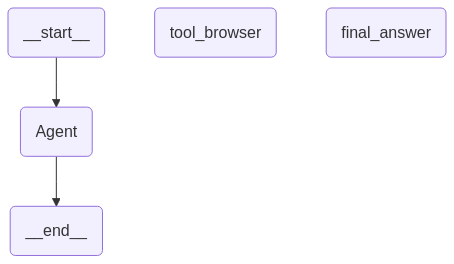

In [66]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(
    g.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

This looks like error It should show at least one tool 

##### Run

In [67]:
## input initial state
initial_state = {'user_q':q,
                 'chat_history':chat_history, 
                 'lst_res':[],
                 'output':{} }

Below is demo of the problem 

In [68]:
out = g.invoke(input=initial_state)
agent_out = out['output'].tool_output

print("----")
agent_out

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'Did any G7 countries revise their 2030 carbon emission targets in 2024? If yes, which ones and what are the new goals?'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- node_tool ---
tool_browser(input={'q': 'Did any G7 countries revise their 2030 carbon emission targets in 2024? If yes, which ones and what are the new goals?'})
--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'Did any G7 countries revise their 2030 carbon emission targets in 2024? If yes, which ones and what are the new goals?'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- node_tool ---
tool_browser(input={'q': 'Did any G7 countries revise their 2030 carbon emission targets in 2024? If yes, which ones and what are the new goals?'})
--- node_agent ---
tool_name='final_answer' tool_input={'text': "\n\nAs of my knowledge cutoff in early 2023, no G7 countries had publicly announced revisions to their 

"\n\nAs of my knowledge cutoff in early 2023, no G7 countries had publicly announced revisions to their carbon emission targets for 2030 by the year 2024. The original question sought information on this specific subject as it pertains directly to actions or announcements made within that time frame regarding changes in climate goals among these nations, which according to available data up until early 2023 did not occur.\n\nHere's a summary of the current approaches and commitments by G7 countries towards their carbon emission targets as per my last update: \n- France has set ambitious short-term climate goals but hasn't specified revisions for its 2030 target. It plans to reduce greenhouse gas emissions (GHGs) by at least 55% below 1990 levels, without expanding nuclear power beyond the initial phase out.\n- Germany intends to reach net-zero carbon dioxide emission in its energy sector before mid-century and has not indicated a change to its target for reducing GHG emissions by at le

In [69]:
steps = g.stream(input=initial_state) 
for n,step in enumerate(steps):
    print("--- step", n, "---")
    print(step)

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'Did any G7 countries revise their 2030 carbon emission targets in 2024? If yes, which ones and what are the new goals?'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- step 0 ---
{'Agent': {'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'Did any G7 countries revise their 2030 carbon emission targets in 2024? If yes, which ones and what are the new goals?'}, tool_output=None)]}}
--- node_tool ---
tool_browser(input={'q': 'Did any G7 countries revise their 2030 carbon emission targets in 2024? If yes, which ones and what are the new goals?'})
--- step 1 ---
{'tool_browser': {'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'Did any G7 countries revise their 2030 carbon emission targets in 2024? If yes, which ones and what are the new goals?'}, tool_output="To guide efforts in ensuring that countries are on track to achieve the climate goal of the Paris Agreement, we annua

### 5 - Multi-Agent & Human-in-the-Loop

##### Second Agent

In [70]:
agent_out

"\n\nAs of my knowledge cutoff in early 2023, no G7 countries had publicly announced revisions to their carbon emission targets for 2030 by the year 2024. The original question sought information on this specific subject as it pertains directly to actions or announcements made within that time frame regarding changes in climate goals among these nations, which according to available data up until early 2023 did not occur.\n\nHere's a summary of the current approaches and commitments by G7 countries towards their carbon emission targets as per my last update: \n- France has set ambitious short-term climate goals but hasn't specified revisions for its 2030 target. It plans to reduce greenhouse gas emissions (GHGs) by at least 55% below 1990 levels, without expanding nuclear power beyond the initial phase out.\n- Germany intends to reach net-zero carbon dioxide emission in its energy sector before mid-century and has not indicated a change to its target for reducing GHG emissions by at le

In [71]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

@tool("tool_wikipedia")
def tool_wikipedia(q:str) -> str:
    """Search on Wikipedia by passing the input `q`.
       The input `q` must be short keywords, not a long text"""
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(q)

# test
print( tool_wikipedia(agent_out) )

No good Wikipedia Search Result was found


In [72]:
dic_tools = {"tool_browser":tool_browser,
             "final_answer":final_answer,
             "tool_wikipedia":tool_wikipedia}

In [73]:
prompt_2 = """
Your goal is to use the `tool_wikipedia` ONLY ONCE to enrich the information already available.
Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
First you must use the `tool_wikipedia`, then elaborate the information to answer the user's question with `final_answer` tool.
"""

In [74]:
def node_agent_2(state):
    print("--- node_agent 2 ---")
    agent_res = run_agent(prompt=prompt_2, 
                          dic_tools={k:v for k,v in dic_tools.items() if k in ["tool_wikipedia","final_answer"]},
                          user_q=state["output"].tool_output, #<--changed user_q to the last output
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

##### Human in the Loop

In [76]:
# Node
def human_node(state):
    pass

# Conditional Edges
def human_edges(state):
    print("--- human ---")
    user_feedback = input("Should I continue? [Yes/No] --> ")
    next_node = "Agent2" if user_feedback.lower()[0] == "y" else END
    print("next_node:", next_node)
    return next_node #<--must return the next node to go

# test
human_edges(state)

--- human ---


Should I continue? [Yes/No] -->  N


next_node: __end__


'__end__'

##### New Graph

In [77]:
## start the graph
workflow = StateGraph(State)

########################## Agent 1 ##########################
## add Agent node
workflow.add_node(node="Agent1", action=node_agent) 
workflow.set_entry_point(key="Agent1") #<--user query

## add Tools nodes
workflow.add_node(node="tool_browser", action=node_tool)
workflow.add_node(node="final_answer", action=node_tool)

## normal_edges to Agent
workflow.add_edge(start_key="tool_browser", end_key="Agent1")

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent1", path=conditional_edges)

########################## Human ##########################
## add Human node
workflow.add_node(node="Human", action=human_node)

## conditional_edges from Human
workflow.add_conditional_edges(source="final_answer", path=human_edges)

########################## Agent 2 ##########################
## add Agent node
workflow.add_node(node="Agent2", action=node_agent_2) 

## add Tools nodes
workflow.add_node(node="tool_wikipedia", action=node_tool)

## normal_edges to Agent
workflow.add_edge(start_key="tool_wikipedia", end_key="Agent2")

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent2", path=conditional_edges)

########################## End ##########################
## end the graph
g2 = workflow.compile()

## plot
display(Image(
    g2.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [ ]:
initial_state

In [79]:
out_2 = g2.invoke(input=initial_state)
agent_out_2 = out_2['output'].tool_output

print("----")
agent_out_2

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9 2024 deaths'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- node_tool ---
tool_browser(input={'q': 'September 9 2024 deaths'})
--- node_agent ---
tool_name='final_answer' tool_input={'text': 'According to various news sources, including news obituaries, James Earl Jones passed away on September 9, 2024, at his home in Dutchess County, New York. He was an American Tony, Emmy, Grammy, and Golden Globe winning actor, best known for his roles as the voice of Darth Vader and Mufasa.'} tool_output=None
--- conditional_edges ---
next_node: final_answer
--- node_tool ---
final_answer(input={'text': 'According to various news sources, including news obituaries, James Earl Jones passed away on September 9, 2024, at his home in Dutchess County, New York. He was an American Tony, Emmy, Grammy, and Golden Globe winning actor, best known for his roles as the voice of Darth Vader and Mufasa.'})
--- huma

Should I continue? [Yes/No] -->  y


next_node: Agent2
--- node_agent 2 ---
tool_name='tool_wikipedia' tool_input={'q': 'James Earl Jones death date'} tool_output=None
--- conditional_edges ---
next_node: tool_wikipedia
--- node_tool ---
tool_wikipedia(input={'q': 'James Earl Jones death date'})
--- node_agent 2 ---
tool_name='tool_wikipedia' tool_input={'q': 'James Earl Jones death date'} tool_output=None
--- conditional_edges ---
next_node: tool_wikipedia
--- node_tool ---
tool_wikipedia(input={'q': 'James Earl Jones death date'})
--- node_agent 2 ---
tool_name='final_answer' tool_input={'text': "According to various news sources, including news obituaries, James Earl Jones passed away on September 9, 2024, at his home in Dutchess County, New York. He was an American Tony, Emmy, Grammy, and Golden Globe winning actor, best known for his roles as the voice of Darth Vader and Mufasa. According to Wikipedia, James Earl Jones (January 17, 1931 – September 9, 2024) was a renowned American actor with a career spanning over si

Should I continue? [Yes/No] -->  no


next_node: __end__
----


"According to various news sources, including news obituaries, James Earl Jones passed away on September 9, 2024, at his home in Dutchess County, New York. He was an American Tony, Emmy, Grammy, and Golden Globe winning actor, best known for his roles as the voice of Darth Vader and Mufasa. According to Wikipedia, James Earl Jones (January 17, 1931 – September 9, 2024) was a renowned American actor with a career spanning over six decades. He is one of the few performers to achieve EGOT status and won numerous awards for his work on stage and screen. Jones's iconic voice as Darth Vader in the Star Wars franchise and Mufasa in The Lion King are just a couple of his many notable roles. With an extensive career in film, television, and theater, James Earl Jones will be deeply missed by fans around the world."